In [358]:
import numpy as np
import pandas as pd
import faiss
import json
# Performance metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [359]:
rung_rule = '/Users/rezadoobary/Downloads/den_graph_data_list_9to10.json'

with open(rung_rule, "r") as f:
    data = json.load(f)

mapping = data['mapping']

In [360]:
# Load training embeddings from loops 6, 7, 8, 9 (trained on 6,7,8,9)
# These are the embeddings from the training set when model was trained on 6,7,8,9
embeddings_6 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/embeddings.npy")
embeddings_7 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/embeddings.npy")
embeddings_8 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/embeddings.npy")
embeddings_9 = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/embeddings.npy")

# Stack training embeddings
train_embeddings = np.vstack([
    embeddings_6,
    embeddings_7,
    embeddings_8,
    embeddings_9
])


# Load test embeddings for loop 11 (full set, non-pos)
# Using train_678910_test_11 since that's what's available for test 11
test_embeddings = np.load("/Users/rezadoobary/Downloads/embeddings/train_6789_test_10/embeddings.npy")
test_predictions = pd.read_csv("/Users/rezadoobary/Downloads/embeddings/train_6789_test_10/helpful-sweep-260_10_predictions.csv")
# Load training predictions for loops 6, 7, 8, 9
prediction_files = [
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_6/helpful-sweep-260_6_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_7/helpful-sweep-260_7_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_8/helpful-sweep-260_8_predictions.csv",
    "/Users/rezadoobary/Downloads/embeddings/train_6789_test_9/helpful-sweep-260_9_predictions.csv"
]

import os

dfs = []
for p in prediction_files:
    df = pd.read_csv(p)
    # Extract loop number from directory name (e.g., "train_6789_test_6" -> 6)
    dir_name = os.path.basename(os.path.dirname(p))
    p_value = int(dir_name.split('_')[-1])  # Extract loop number from "test_X"
    df["loop"] = p_value
    dfs.append(df)

train_results = pd.concat(dfs, ignore_index=True)


In [361]:
train_embeddings

array([[-0.06513688, -0.43883666, -0.12748252, ..., -0.12289405,
         0.32407692, -0.44578686],
       [-0.01024295, -0.43380463, -0.08935158, ..., -0.14046158,
         0.34834313, -0.43079594],
       [-0.12053477, -0.26487815, -0.11677235, ..., -0.09707345,
         0.24196133, -0.27154696],
       ...,
       [ 1.9840134 , -0.9238055 ,  0.83841944, ...,  1.5566293 ,
         2.1962388 , -0.47035477],
       [ 1.0400565 , -0.5359498 ,  0.68686634, ...,  0.59593457,
         1.245584  , -0.5786948 ],
       [ 0.83074456, -0.2839991 ,  0.47292632, ...,  0.56883955,
         0.8235044 , -0.2606936 ]], dtype=float32)

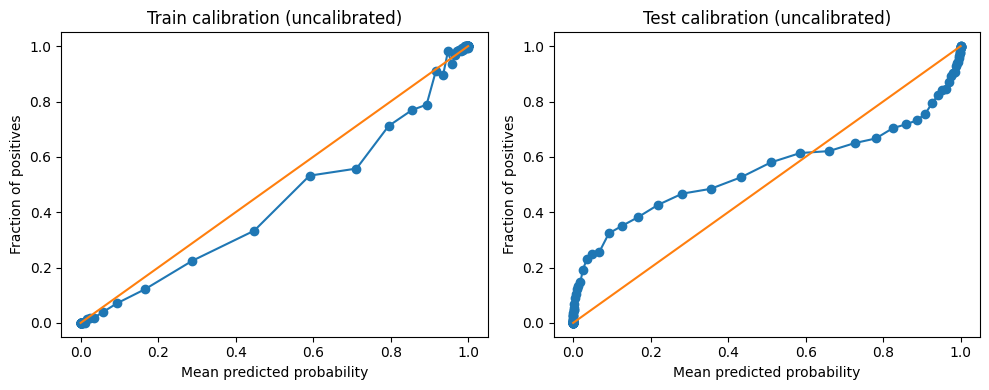

In [362]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# --- Train ---
y_train = train_results['y_true'].values
p_train = train_results['y_prob'].values

frac_pos_tr, mean_pred_tr = calibration_curve(
    y_train,
    p_train,
    n_bins=100,
    strategy="quantile"
)

# --- Test ---
y_test = test_predictions['y_true'].values
p_test = test_predictions['y_prob'].values

frac_pos_te, mean_pred_te = calibration_curve(
    y_test,
    p_test,
    n_bins=100,
    strategy="quantile"
)

# --- Plot ---
plt.figure(figsize=(10, 4))

# Train
plt.subplot(1, 2, 1)
plt.plot(mean_pred_tr, frac_pos_tr, marker='o')
plt.plot([0, 1], [0, 1])
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Train calibration (uncalibrated)")

# Test
plt.subplot(1, 2, 2)
plt.plot(mean_pred_te, frac_pos_te, marker='o')
plt.plot([0, 1], [0, 1])
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Test calibration (uncalibrated)")

plt.tight_layout()
plt.show()


SO we have 
1. distribution for test
2. embeddings for train and test


Can we identify a segment of the ansatz that can be removed larger than current approach.

In [363]:
roc_auc_score(train_results['y_true'],train_results['y_prob'])

0.9969042008061201

In [364]:
roc_auc_score(test_predictions['y_true'],test_predictions['y_prob'])

0.9697997488900569

In [365]:
threshold = train_results[train_results['y_true'] == 1]['y_prob'].min()

df = test_predictions[test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

y_true
0    82663
1     1263
Name: count, dtype: int64
0.8105089764582455


In [366]:
threshold = test_predictions[test_predictions['y_true'] == 1]['y_prob'].min()

df = test_predictions[test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

y_true
0    30840
Name: count, dtype: int64
0.3023855513829923


In [367]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2, random_state=0)
pca.fit(train_embeddings)

train_proj = pca.transform(train_embeddings)
test_proj = pca.transform(test_embeddings)

p = test_predictions["y_prob"].values
entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

entropy = entropy / np.log(p.shape)  # now in [0, 1]


p = train_results["y_prob"].values
train_entropy = -(p*np.log(p+1e-12) + (1-p)*np.log(1-p+1e-12))

train_entropy = train_entropy / np.log(p.shape)  # now in [0, 1]

In [368]:
# cosine sim


import numpy as np

def l2_normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True) 

# normalize
train_norm = train_embeddings / np.linalg.norm(train_embeddings, axis=1, keepdims=True)
test_norm = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)

import faiss

d = train_norm.shape[1]

index = faiss.IndexFlatIP(d)  # inner product
index.add(train_norm.astype("float32"))

sims, _ = index.search(test_norm.astype("float32"), 5)

test_predictions["max_cosine_sim"] = sims[:, 0]
test_predictions["top5_cosine_sim"] = sims.mean(axis=1)

In [369]:
train_results[train_results['y_true'] == 1]['y_prob'].min()

0.014444668

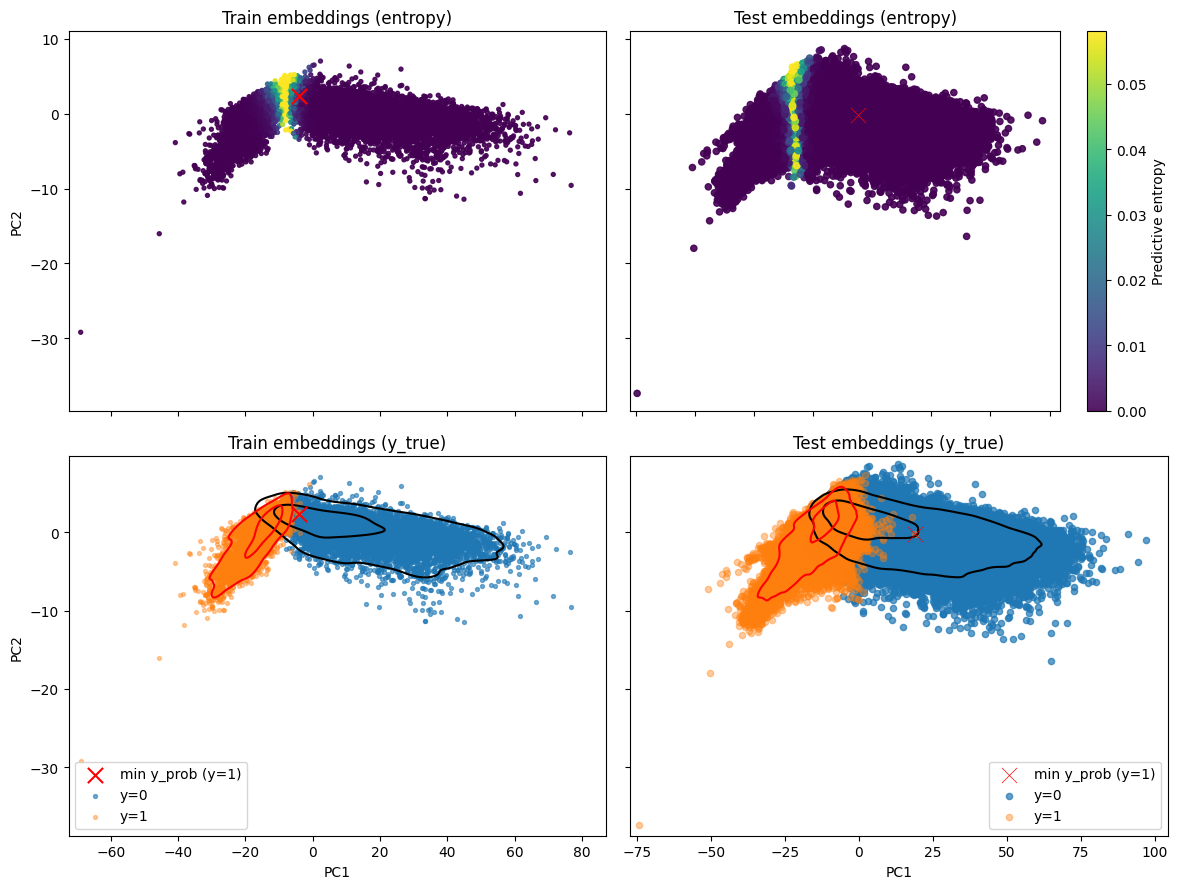

In [370]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

idx_min_prob = train_results.loc[
    train_results["y_true"] == 1, "y_prob"
].idxmin()

idx_min_prob_test = test_predictions.loc[
    test_predictions["y_true"] == 1, "y_prob"
].idxmin()

x_cross = train_proj[idx_min_prob, 0]
y_cross = train_proj[idx_min_prob, 1]

x_cross_test = test_proj[idx_min_prob_test, 0]
y_cross_test = test_proj[idx_min_prob_test, 1]

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex="col", sharey="row")

norm = colors.Normalize(
    vmin=min(train_entropy.min(), train_entropy.min()),
    vmax=max(entropy.max(), entropy.max())
)
# =======================
# TOP ROW — your existing plots
# =======================

axes[0, 0].scatter(
    x_cross,
    y_cross,
    marker="x",
    s=120,
    linewidths=1.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)


axes[1, 0].scatter(
    x_cross,
    y_cross,
    marker="x",
    s=120,
    linewidths=1.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)

axes[0, 1].scatter(
    x_cross_test,
    y_cross_test,
    marker="x",
    s=120,
    linewidths=0.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)

axes[1, 1].scatter(
    x_cross_test,
    y_cross_test,
    marker="x",
    s=120,
    linewidths=0.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)


sc_train = axes[0, 0].scatter(
    train_proj[:, 0],
    train_proj[:, 1],
    c=train_entropy,
    cmap="viridis",
    norm=norm,
    s=8,
    alpha=0.9
)
axes[0, 0].set_title("Train embeddings (entropy)")
axes[0, 0].set_ylabel("PC2")

sc_test = axes[0, 1].scatter(
    test_proj[:, 0],
    test_proj[:, 1],
    c=entropy,
    cmap="viridis",
    norm=norm,
    s=20,
    alpha=0.9
)
axes[0, 1].set_title("Test embeddings (entropy)")
plt.colorbar(sc_train, ax=axes[0, 1], label="Predictive entropy")

# =======================
# BOTTOM LEFT — Train PCA by y_true
# =======================
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 0, 0],
    train_proj[train_results['y_true'] == 0, 1],
    s=8,
    alpha=0.6,
    label="y=0"
)
axes[1, 0].scatter(
    train_proj[train_results['y_true'] == 1, 0],
    train_proj[train_results['y_true'] == 1, 1],
    s=8,
    alpha=0.4,
    label="y=1"
)
axes[1, 0].set_title("Train embeddings (y_true)")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")
axes[1, 0].legend()

# =======================
# BOTTOM RIGHT — Test PCA by y_true
# =======================
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 0, 0],
    test_proj[test_predictions['y_true'] == 0, 1],
    s=20,
    alpha=0.7,
    label="y=0",
    
)
axes[1, 1].scatter(
    test_proj[test_predictions['y_true'] == 1, 0],
    test_proj[test_predictions['y_true'] == 1, 1],
    s=20,
    alpha=0.4,
    label="y=1",
)
axes[1, 1].set_title("Test embeddings (y_true)")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].legend()





import seaborn as sns

# Class 0
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 0, 0],
    y=train_proj[train_results["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=0 density",
)

# Class 1
sns.kdeplot(
    x=train_proj[train_results["y_true"] == 1, 0],
    y=train_proj[train_results["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=1 density",
)





# Class 0
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 0, 0],
    y=test_proj[test_predictions["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 1]
)

# Class 1
sns.kdeplot(
    x=test_proj[test_predictions["y_true"] == 1, 0],
    y=test_proj[test_predictions["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 1]
)

plt.tight_layout()
plt.show()


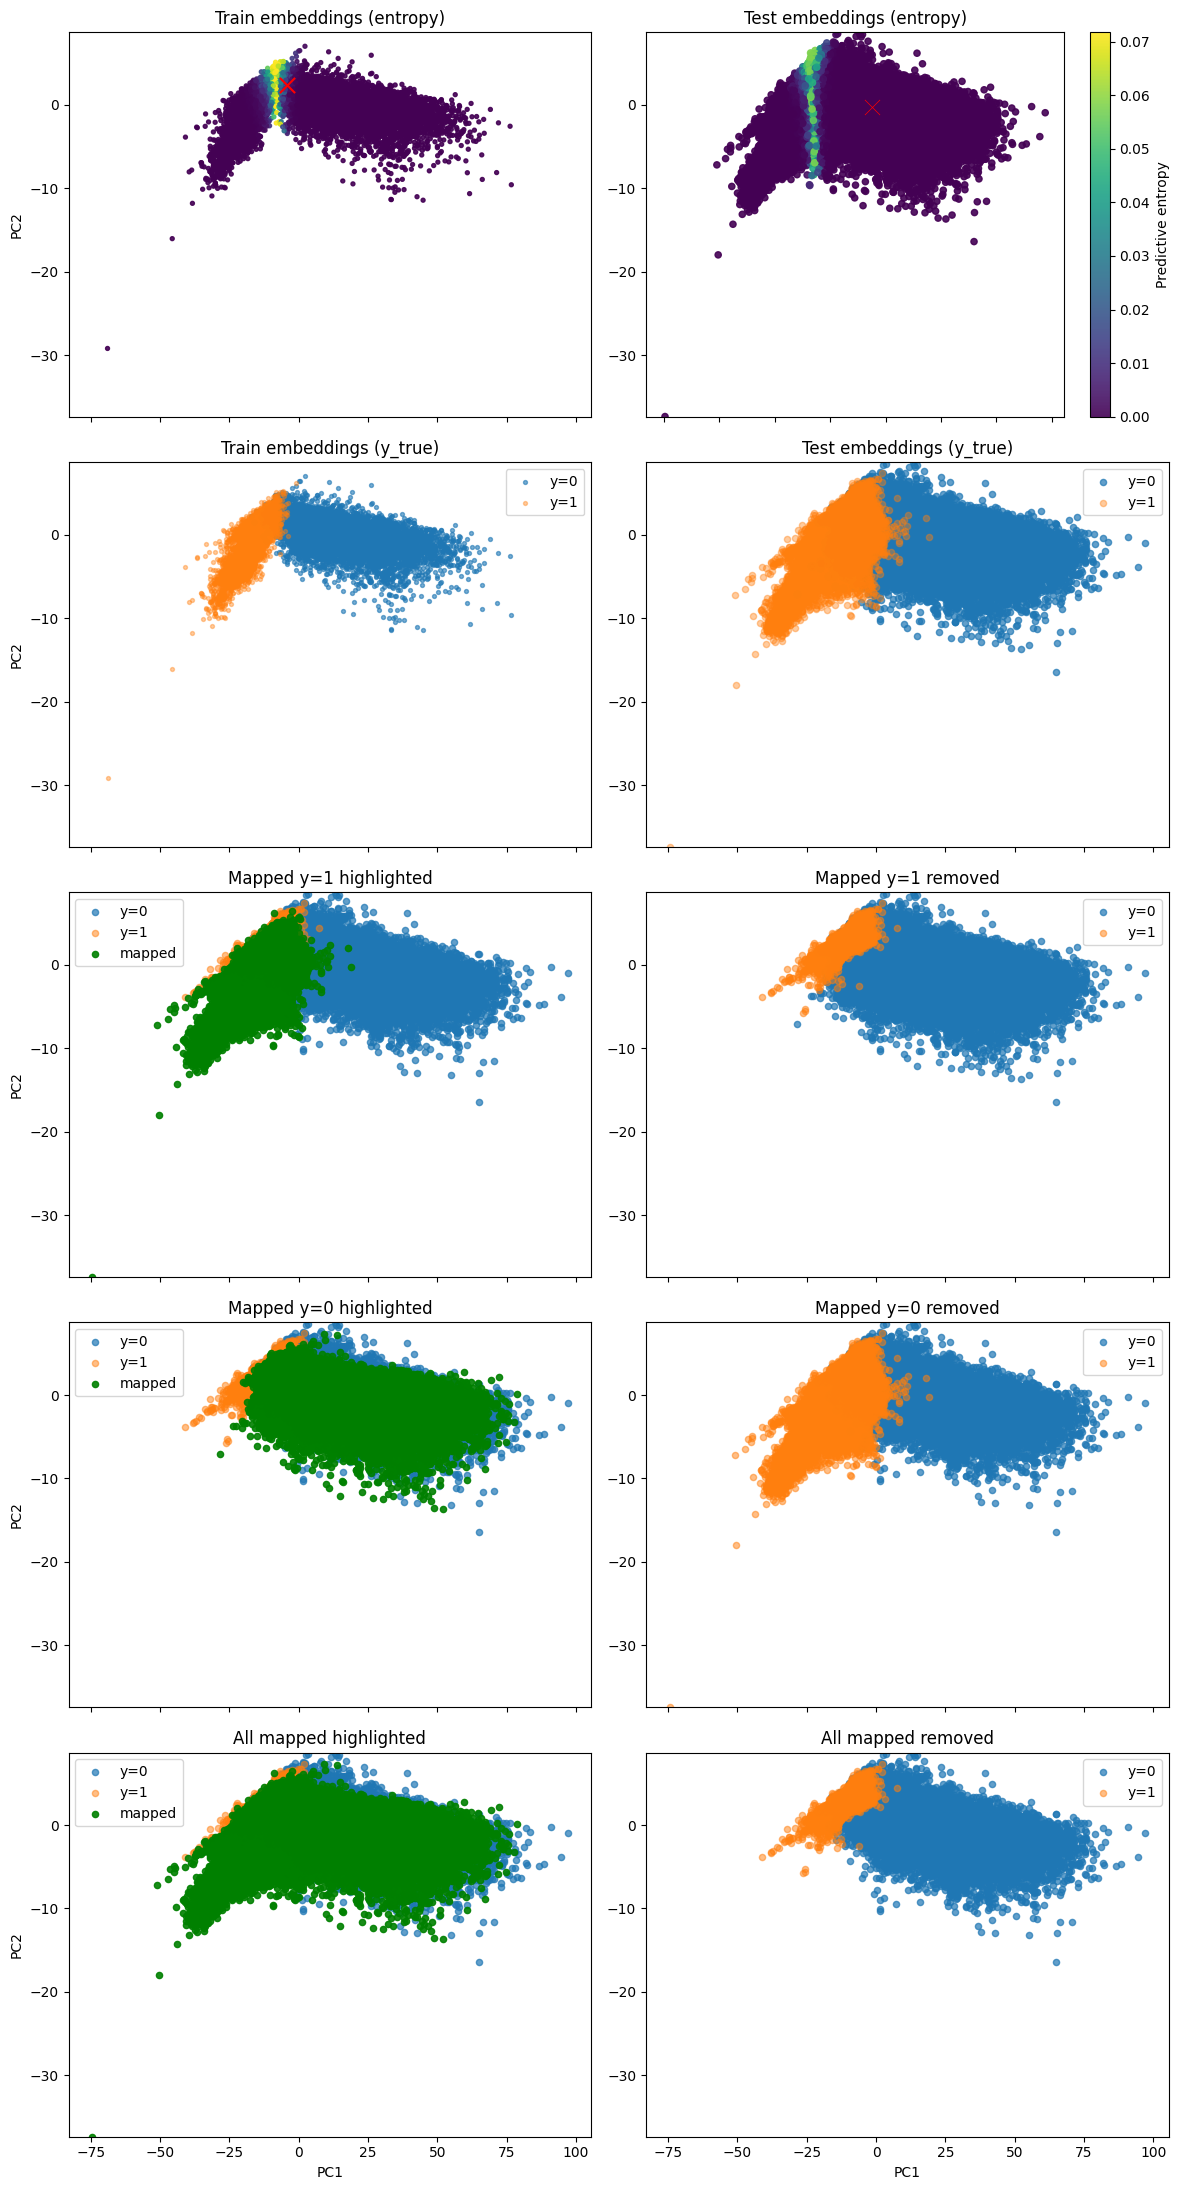

In [382]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# =======================
# Find special points
# =======================
idx_min_prob = train_results.loc[
    train_results["y_true"] == 1, "y_prob"
].idxmin()

idx_min_prob_test = test_predictions.loc[
    test_predictions["y_true"] == 1, "y_prob"
].idxmin()

x_cross = train_proj[idx_min_prob, 0]
y_cross = train_proj[idx_min_prob, 1]

x_cross_test = test_proj[idx_min_prob_test, 0]
y_cross_test = test_proj[idx_min_prob_test, 1]

# =======================
# Masks (defined once)
# =======================
test_idx = test_predictions.index.to_numpy()

mask_y0 = test_predictions["y_true"].to_numpy() == 0
mask_y1 = test_predictions["y_true"].to_numpy() == 1
mask_mapped = np.isin(test_idx, list(mapping))
mask_unmapped = ~mask_mapped

# =======================
# FIGURE (5 x 2)
# =======================
fig, axes = plt.subplots(5, 2, figsize=(12, 22), sharex="col")

# ---- FIX Y AXIS GLOBALLY (based on full test proj)
ymin, ymax = test_proj[:, 1].min(), test_proj[:, 1].max()
for ax in axes.flat:
    ax.set_ylim(ymin, ymax)

norm = colors.Normalize(
    vmin=min(train_entropy.min(), entropy.min()),
    vmax=max(train_entropy.max(), entropy.max())
)

# =======================
# ROW 1 — Entropy
# =======================
axes[0, 0].scatter(
    x_cross, y_cross,
    marker="x", s=120, linewidths=1.5,
    color="red", zorder=10
)
axes[0, 1].scatter(
    x_cross_test, y_cross_test,
    marker="x", s=120, linewidths=0.5,
    color="red", zorder=10
)

sc_train = axes[0, 0].scatter(
    train_proj[:, 0], train_proj[:, 1],
    c=train_entropy, cmap="viridis",
    norm=norm, s=8, alpha=0.9
)
axes[0, 0].set_title("Train embeddings (entropy)")
axes[0, 0].set_ylabel("PC2")

sc_test = axes[0, 1].scatter(
    test_proj[:, 0], test_proj[:, 1],
    c=entropy, cmap="viridis",
    norm=norm, s=20, alpha=0.9
)
axes[0, 1].set_title("Test embeddings (entropy)")
plt.colorbar(sc_train, ax=axes[0, 1], label="Predictive entropy")

# =======================
# ROW 2 — y_true
# =======================
axes[1, 0].scatter(
    train_proj[train_results["y_true"] == 0, 0],
    train_proj[train_results["y_true"] == 0, 1],
    s=8, alpha=0.6, label="y=0"
)
axes[1, 0].scatter(
    train_proj[train_results["y_true"] == 1, 0],
    train_proj[train_results["y_true"] == 1, 1],
    s=8, alpha=0.4, label="y=1"
)
axes[1, 0].set_title("Train embeddings (y_true)")
axes[1, 0].set_ylabel("PC2")
axes[1, 0].legend()

axes[1, 1].scatter(
    test_proj[mask_y0, 0],
    test_proj[mask_y0, 1],
    s=20, alpha=0.7, label="y=0"
)
axes[1, 1].scatter(
    test_proj[mask_y1, 0],
    test_proj[mask_y1, 1],
    s=20, alpha=0.4, label="y=1"
)
axes[1, 1].set_title("Test embeddings (y_true)")
axes[1, 1].legend()

# =======================
# Helper for rows 3–5
# =======================
def plot_ablation_pair(ax_l, ax_r, highlight_mask, title_l, title_r):
    # ----- LEFT: highlight mapped subset in green
    ax_l.scatter(
        test_proj[mask_unmapped & mask_y0, 0],
        test_proj[mask_unmapped & mask_y0, 1],
        s=20, alpha=0.7, label="y=0"
    )
    ax_l.scatter(
        test_proj[mask_unmapped & mask_y1, 0],
        test_proj[mask_unmapped & mask_y1, 1],
        s=20, alpha=0.5, label="y=1"
    )
    ax_l.scatter(
        test_proj[highlight_mask, 0],
        test_proj[highlight_mask, 1],
        s=20, alpha=0.9, color="green", label="mapped"
    )
    ax_l.set_title(title_l)
    ax_l.set_ylabel("PC2")
    ax_l.legend()

    # ----- RIGHT: remove highlighted points
    keep = ~highlight_mask
    ax_r.scatter(
        test_proj[keep & mask_y0, 0],
        test_proj[keep & mask_y0, 1],
        s=20, alpha=0.7, label="y=0"
    )
    ax_r.scatter(
        test_proj[keep & mask_y1, 0],
        test_proj[keep & mask_y1, 1],
        s=20, alpha=0.5, label="y=1"
    )
    ax_r.set_title(title_r)
    ax_r.legend()

# =======================
# ROW 3 — mapped y=1
# =======================
plot_ablation_pair(
    axes[2, 0], axes[2, 1],
    highlight_mask=mask_mapped & mask_y1,
    title_l="Mapped y=1 highlighted",
    title_r="Mapped y=1 removed"
)

# =======================
# ROW 4 — mapped y=0
# =======================
plot_ablation_pair(
    axes[3, 0], axes[3, 1],
    highlight_mask=mask_mapped & mask_y0,
    title_l="Mapped y=0 highlighted",
    title_r="Mapped y=0 removed"
)

# =======================
# ROW 5 — all mapped
# =======================
plot_ablation_pair(
    axes[4, 0], axes[4, 1],
    highlight_mask=mask_mapped,
    title_l="All mapped highlighted",
    title_r="All mapped removed"
)

axes[4, 0].set_xlabel("PC1")
axes[4, 1].set_xlabel("PC1")

plt.tight_layout()
plt.show()


In [373]:
len(mapping)

111148

In [377]:
max(mapping)

153251

<Axes: >

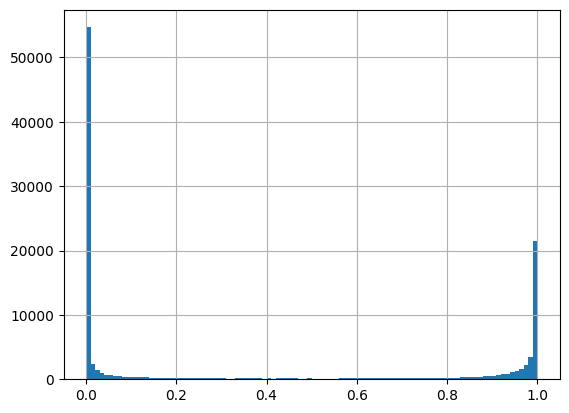

In [379]:
test_predictions.iloc[mapping]['y_prob'].hist(bins = 100)

In [376]:
test_predictions['y_true'].value_counts()

y_true
0    101989
1     51263
Name: count, dtype: int64

In [299]:
test_predictions['entropy'] = entropy
train_results['entropy'] = train_entropy

# Find High-Entropy Train Cases and Closest Test Embeddings


In [328]:
# Set threshold for high entropy (e.g., top 10% or 90th percentile)
entropy_threshold = np.percentile(train_entropy, 90)
print(entropy_threshold)
# Filter high entropy train cases
high_entropy_mask = train_entropy >= entropy_threshold
high_entropy_train_results = train_results[high_entropy_mask].copy()
low_entropy_train_results = train_results[~high_entropy_mask].copy()
high_entropy_train_embeddings = train_embeddings[high_entropy_mask]
low_entropy_train_embeddings = train_embeddings[~high_entropy_mask]

print('auc',roc_auc_score(high_entropy_train_results['y_true'],high_entropy_train_results['y_prob']),roc_auc_score(low_entropy_train_results['y_true'],low_entropy_train_results['y_prob']))
print(high_entropy_train_embeddings.shape)
print(high_entropy_train_results.shape)
print(low_entropy_train_results.shape)


0.026681916736682285
auc 0.8246166895987139 0.9993972999339462
(1560, 128)
(1560, 5)
(14039, 5)


In [329]:
# Normalize embeddings for cosine similarity
train_norm = train_embeddings / np.linalg.norm(train_embeddings, axis=1, keepdims=True)
test_norm = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)
high_entropy_train_norm = high_entropy_train_embeddings / np.linalg.norm(high_entropy_train_embeddings, axis=1, keepdims=True)

d = high_entropy_train_norm.shape[1]

index = faiss.IndexFlatIP(d)  # Inner product for cosine similarity (after normalization)
index.add(high_entropy_train_norm.astype("float32"))

k = 5  # Number of nearest neighbors to find
sims, indices = index.search(test_norm.astype("float32"), k)

# For each test embedding, get the maximum cosine similarity to any high-entropy train embedding
test_predictions['max_cosine_sim_to_high_entropy'] = sims[:, 0]  # Maximum similarity
test_predictions['mean_cosine_sim_to_high_entropy'] = sims.mean(axis=1)  # Mean similarity to top k


<Axes: >

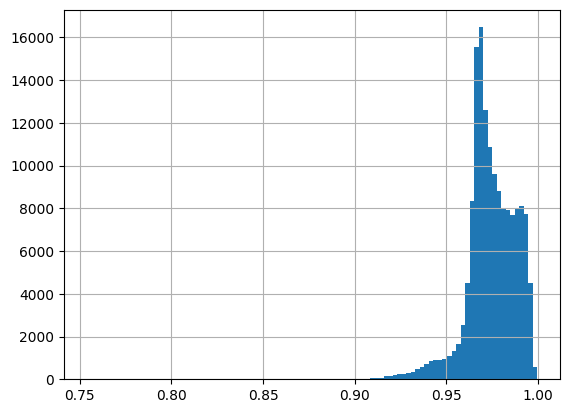

In [330]:
test_predictions['max_cosine_sim_to_high_entropy'].hist(bins =100)

<Axes: >

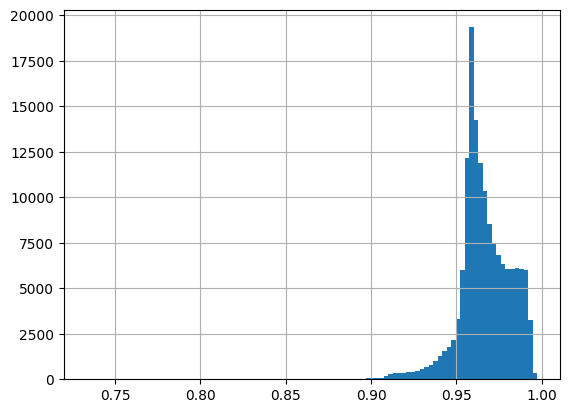

In [331]:
test_predictions['mean_cosine_sim_to_high_entropy'].hist(bins =100)

In [332]:
# cheating a bit here

In [333]:
similarity_threshold = np.percentile(test_predictions['max_cosine_sim_to_high_entropy'], 95)
similarity_threshold

0.9937823355197907

(7663, 9)


<Axes: >

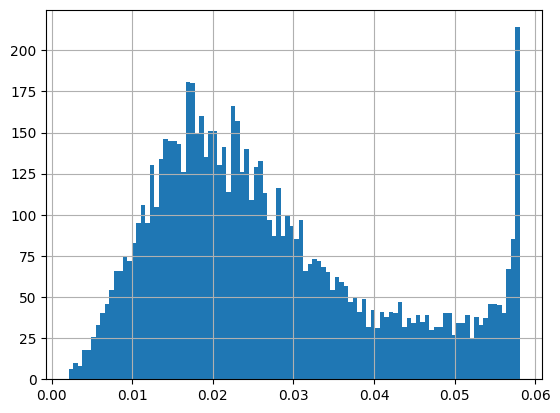

In [357]:
print(test_predictions[test_predictions['max_cosine_sim_to_high_entropy'] >= similarity_threshold].shape)
test_predictions[test_predictions['max_cosine_sim_to_high_entropy'] >= similarity_threshold]['entropy'].hist(bins = 100)

(145589, 9)


<Axes: >

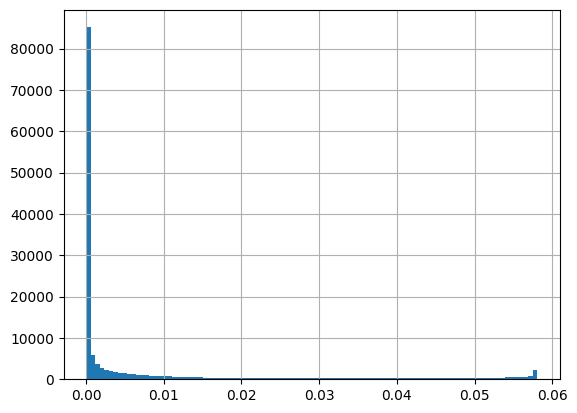

In [335]:
print(test_predictions[test_predictions['max_cosine_sim_to_high_entropy'] < similarity_threshold].shape)
test_predictions[test_predictions['max_cosine_sim_to_high_entropy'] < similarity_threshold]['entropy'].hist(bins = 100)

In [336]:
# Identify test embeddings that are closest to high-entropy train embeddings
# Set a similarity threshold (e.g., top 10% = 90th percentile of HIGH similarities)
# HIGH cosine similarity = CLOSE to high-entropy train embeddings


# Select test cases with HIGH similarity (closest to high-entropy train)
close_to_high_entropy_mask = test_predictions['max_cosine_sim_to_high_entropy'] >= similarity_threshold
close_test_embeddings = test_embeddings[close_to_high_entropy_mask]
close_test_predictions = test_predictions[close_to_high_entropy_mask].copy()

not_close_mask = ~close_to_high_entropy_mask
not_close_test_predictions = test_predictions[not_close_mask].copy()
not_close_mask_embeddings = test_embeddings[not_close_mask]

In [337]:
# Summary statistics comparing close vs not-close test cases
print(f"\nClose to High-Entropy Test (n={close_test_predictions.shape[0]}):")
print(f"  ROC-AUC: {roc_auc_score(close_test_predictions['y_true'], close_test_predictions['y_prob']):.4f}")
print(f"  Mean y_prob: {close_test_predictions['y_prob'].mean():.6f}")
print(f"  Mean entropy: {close_test_predictions['entropy'].mean():.4f}")
print(f"  Max entropy: {close_test_predictions['entropy'].max():.4f}")
print(f"  Positive rate: {(close_test_predictions['y_true'] == 1).mean():.4f}")

print(f"\nLow-Entropy Test (n={not_close_test_predictions.shape[0]}):")
print(f"  ROC-AUC: {roc_auc_score(not_close_test_predictions['y_true'], not_close_test_predictions['y_prob']):.4f}")
print(f"  Mean y_prob: {not_close_test_predictions['y_prob'].mean():.6f}")
print(f"  Mean entropy: {not_close_test_predictions['entropy'].mean():.4f}")
print(f"  Max entropy: {not_close_test_predictions['entropy'].max():.4f}")
print(f"  Positive rate: {(not_close_test_predictions['y_true'] == 1).mean():.4f}")


print(f"\nALL Test (n={test_predictions.shape[0]}):")
print(f"  ALL ROC-AUC: {roc_auc_score(test_predictions['y_true'], test_predictions['y_prob']):.4f}")




Close to High-Entropy Test (n=7663):
  ROC-AUC: 0.7428
  Mean y_prob: 0.697596
  Mean entropy: 0.0268
  Max entropy: 0.0581
  Positive rate: 0.6856

Low-Entropy Test (n=145589):
  ROC-AUC: 0.9740
  Mean y_prob: 0.303416
  Mean entropy: 0.0081
  Max entropy: 0.0581
  Positive rate: 0.3160

ALL Test (n=153252):
  ALL ROC-AUC: 0.9698


In [338]:
threshold = train_results[train_results['y_true'] == 1]['y_prob'].min()
print(threshold)
df = test_predictions[test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

0.014444668
y_true
0    82663
1     1263
Name: count, dtype: int64
0.8105089764582455


In [339]:
threshold = test_predictions[test_predictions['y_true'] == 1]['y_prob'].min()
print(threshold)
df = test_predictions[test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

6.680335e-11
y_true
0    30840
Name: count, dtype: int64
0.3023855513829923


In [340]:
threshold = low_entropy_train_results[low_entropy_train_results['y_true'] == 1]['y_prob'].min()
print(threshold)
df = not_close_test_predictions[not_close_test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

0.014444668
y_true
0    82623
1     1251
Name: count, dtype: int64
0.8101167772995127


In [341]:
threshold = not_close_test_predictions[not_close_test_predictions['y_true'] == 1]['y_prob'].min()
print(threshold)
df = not_close_test_predictions[not_close_test_predictions['y_prob'] < threshold]['y_true'].value_counts()
print(df)
print(df[0]/(test_predictions['y_true'] == 0).sum())

6.680335e-11
y_true
0    30840
Name: count, dtype: int64
0.3023855513829923


In [342]:
train_proj.shape, test_proj.shape


((15599, 2), (153252, 2))

In [343]:
train_proj_low_entropy = train_proj[~high_entropy_mask]
test_proj_low_entropy = test_proj[not_close_mask]
train_low_entropy = train_results[~high_entropy_mask]['entropy'].values
test_low_entropy = test_predictions[not_close_mask]['entropy'].values

train_low_entropy_results = train_results[~high_entropy_mask]
test_low_entropy_results = test_predictions[not_close_mask]

train_proj_low_entropy.shape, test_proj_low_entropy.shape

((14039, 2), (145589, 2))

In [344]:
train_low_entropy.max()

0.026676601128269983

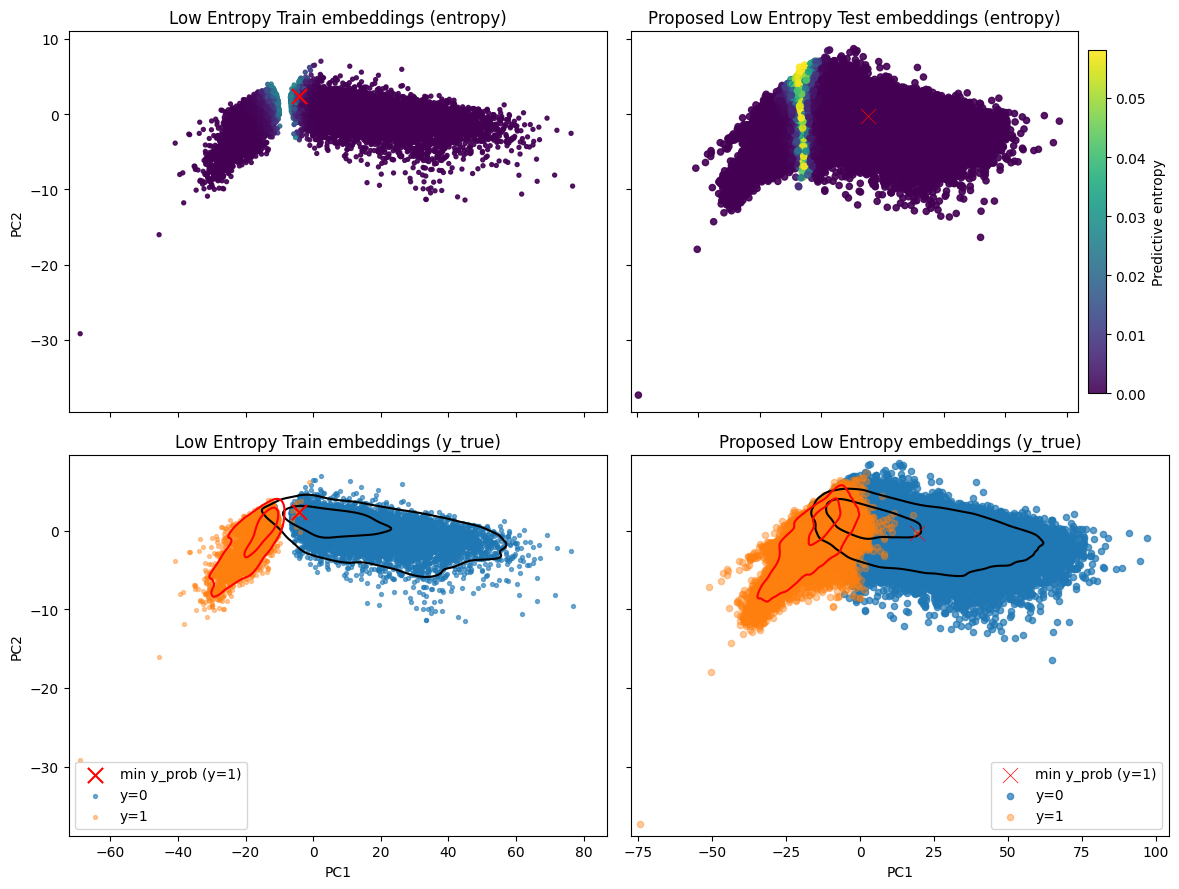

In [354]:
# Create the same 2x2 plot structure for non-challenging cases
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex="col", sharey="row")


idx_min_prob = train_low_entropy_results.loc[
    train_low_entropy_results["y_true"] == 1, "y_prob"
].idxmin()

idx_min_prob_test = test_low_entropy_results.loc[
    test_low_entropy_results["y_true"] == 1, "y_prob"
].idxmin()

x_cross = train_proj[idx_min_prob, 0]
y_cross = train_proj[idx_min_prob, 1]

x_cross_test = test_proj[idx_min_prob_test, 0]
y_cross_test = test_proj[idx_min_prob_test, 1]

norm = colors.Normalize(
    vmin=min(train_low_entropy.min(), test_low_entropy.min()),
    vmax=max(train_low_entropy.max(), test_low_entropy.max())
)
# =======================
# TOP ROW — Entropy plots
# =======================
sc_train = axes[0, 0].scatter(
    train_proj_low_entropy[:, 0],
    train_proj_low_entropy[:, 1],
    c=train_low_entropy,
    cmap="viridis",
    norm=norm,
    s=8,
    alpha=0.9
)

axes[0, 0].set_title("Low Entropy Train embeddings (entropy)")
axes[0, 0].set_ylabel("PC2")

sc_test = axes[0, 1].scatter(
    test_proj_low_entropy[:, 0],
    test_proj_low_entropy[:, 1],
    c=test_low_entropy,
    cmap="viridis",
    norm=norm,
    s=20,
    alpha=0.9
)
axes[0, 1].set_title("Proposed Low Entropy Test embeddings (entropy)")

cbar = fig.colorbar(
    sc_train,         
    ax=axes[0, 1],    
    location="right",
    shrink=0.9,
    pad=0.02
)
cbar.set_label("Predictive entropy")

axes[0, 0].scatter(
    x_cross,
    y_cross,
    marker="x",
    s=120,
    linewidths=1.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)


axes[1, 0].scatter(
    x_cross,
    y_cross,
    marker="x",
    s=120,
    linewidths=1.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)

axes[0, 1].scatter(
    x_cross_test,
    y_cross_test,
    marker="x",
    s=120,
    linewidths=0.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)

axes[1, 1].scatter(
    x_cross_test,
    y_cross_test,
    marker="x",
    s=120,
    linewidths=0.5,
    color="red",
    zorder=10,
    label="min y_prob (y=1)"
)


# =======================
# BOTTOM LEFT — Train PCA by y_true
# =======================
axes[1, 0].scatter(
    train_proj_low_entropy[train_low_entropy_results['y_true'] == 0, 0],
    train_proj_low_entropy[train_low_entropy_results['y_true'] == 0, 1],
    s=8,
    alpha=0.6,
    label="y=0"
)
axes[1, 0].scatter(
    train_proj_low_entropy[train_low_entropy_results['y_true'] == 1, 0],
    train_proj_low_entropy[train_low_entropy_results['y_true'] == 1, 1],
    s=8,
    alpha=0.4,
    label="y=1"
)
axes[1, 0].set_title("Low Entropy Train embeddings (y_true)")
axes[1, 0].set_xlabel("PC1")
axes[1, 0].set_ylabel("PC2")
axes[1, 0].legend()




# =======================
# BOTTOM RIGHT — Test PCA by y_true
# =======================
axes[1, 1].scatter(
    test_proj_low_entropy[test_low_entropy_results['y_true'] == 0, 0],
    test_proj_low_entropy[test_low_entropy_results['y_true'] == 0, 1],
    s=20,
    alpha=0.7,
    label="y=0",
)
axes[1, 1].scatter(
    test_proj_low_entropy[test_low_entropy_results['y_true'] == 1, 0],
    test_proj_low_entropy[test_low_entropy_results['y_true'] == 1, 1],
    s=20,
    alpha=0.4,
    label="y=1",
)
axes[1, 1].set_title("Proposed Low Entropy embeddings (y_true)")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].legend()

# Add density plots
sns.kdeplot(
    x=train_proj_low_entropy[train_low_entropy_results["y_true"] == 0, 0],
    y=train_proj_low_entropy[train_low_entropy_results["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=0 density",
)

# Class 1 - Train
sns.kdeplot(
    x=train_proj_low_entropy[train_low_entropy_results["y_true"] == 1, 0],
    y=train_proj_low_entropy[train_low_entropy_results["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 0],
    label="y=1 density",
)

# Class 0 - Test
sns.kdeplot(
    x=test_proj_low_entropy[test_low_entropy_results["y_true"] == 0, 0],
    y=test_proj_low_entropy[test_low_entropy_results["y_true"] == 0, 1],
    levels=3,
    color="black",
    linewidths=1.5,
    ax=axes[1, 1]
)

# Class 1 - Test
sns.kdeplot(
    x=test_proj_low_entropy[test_low_entropy_results["y_true"] == 1, 0],
    y=test_proj_low_entropy[test_low_entropy_results["y_true"] == 1, 1],
    levels=3,
    color="red",
    linewidths=1.5,
    ax=axes[1, 1]
)


plt.tight_layout()
plt.show()


there are two thing we want to try and do.

1. remove sections of uncertainty from training inconsistency.
2. remove sections where test might be OOD.
3. want to do this from the training dataset only though.